#### BST 267: Introduction to Social and Biological Networks (2017)
# Final Project: Network Models for the Study of HIV/AIDS

HIV is a worldwide pandemic with an estimated 2.5 million new infections per year driven by biological and behavioral factors. Combining various strategies appears to be the most promising approach to HIV prevention, but it introduces financial, ethical, and logistical complexities that can best be investigated by using simulation-based approaches. Because sexually transmitted HIV spreads among sero-discordant couples, network models offer a potentially powerful paradigm for understanding the spread of the disease and how to design effective prevention measures. 

Given that mechanistic models directly model individual-level behaviors–modification of which is the foundation of most prevention measures–they are a natural fit for studying HIV. The mechanistic network model developed by Morris and Kretzschmar has highlighted the potential impact of concurrency and assortativity on epidemic spread in sub-Saharan Africa. It was designed to evaluate settings where the population has a mix of monogamous and concurrent relationships; because it is believed that the HIV epidemic in sub-Saharan Africa is driven by heterosexual relationships, the model only includes partnerships between people of the opposite sex, leading to bipartite graphs. The model introduces a stochastic rule for partner mixing, which can depend both on nodal attributes and properties of the network, making it very generalizable. 

We consider a population that consists of two subpopulations, which we identified as the males and females. We set the size of subpopulations to 200 (total 400 nodes), and the relationships among the population members, always between a male and a female, form and dissolve over time. At each time step, an individual can form new partnerships, dissolve existing partnerships, or both. We first consider three mechanisms for tie formation and one mechanism for tie dissolution, and we then specify the network models that combine these mechanisms in simple ways. For the model to reach a stationary state requires a burn-in step, where one starts the simulation from an empty bipartite graph and then proceeds with the simulation applying the above rules until stationarity is reached.

In [68]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as ss

## Question 1: Three tie formation mechanisms 

Write three functions that each add a single tie between a male and a female to the network. Each function will have its own specific constraints about the placement of a tie, and the goal is to have each function repeat the tie formation process until one tie has been placed. All functions should return the absolute value of the difference in the degrees of the two nodes that were connected. For example, if one of the nodes has degree 3 and the other has degree 5, the absolute difference in degree is 2. All functions should take in the following four arguments: network `G`, a list of male nodes called `males`, a list of female nodes called `females`, and degree cut-off parameter `d_m`. Here are the specifications for the three functions:

- Function `add_random_tie`: Add a new tie between a randomly chosen male node and a randomly chosen female node that do not already have an edge between them subject to the constraint that each node have degree less than `d_m`. 
- Function `add_assortative_tie`: Add a new tie between a randomly chosen male node and a randomly chosen female node subject to the constraints that (i) each node has degree less than `d_m` and (ii) the absolute difference in the degrees of the two nodes is **less than or equal to** a fifth input argument called `threshold`. 
- Function `add_disassortative_tie`: Add a new tie between a randomly chosen male node and a randomly chosen female node subject to the constraints that (i) each node has degree less than `d_m` and (ii) the absolute difference in the degrees of the two nodes is **greater than or equal to** a fifth input argument called `threshold`. 

You should take care to always add a **new** tie rather than duplicating an existing one. The function definition lines are given below.

In [69]:
def add_random_tie(G, males, females, d_m):
    #select a man and woman to fence post
    man = random.choice(males)
    woman = random.choice(females)
    #guarantees that we add a node
    while (G.degree(man) >= d_m) or (G.degree(woman) >= d_m) or (man in G.neighbors(woman)):
        man = random.choice(males)
        woman = random.choice(females)
    #once we selected a sufficient man and woman
    #get the difference 
    diff = abs(G.degree(man) - G.degree(woman))
    #add the edge
    G.add_edge(man, woman)
    return(diff)

def add_assortative_tie(G, males, females, d_m, threshold):

    tie = 0

    while tie == 0:
        man = random.choice(males)
        woman = random.choice(females)
        diff = abs(G.degree(man) - G.degree(woman))
        if ((G.degree(man) >= d_m) or (G.degree(woman) >= d_m)) or (diff > threshold) or (woman in G.neighbors(man)):
            continue
        else: 
            break

    #add an edge
    G.add_edge(man, woman)
    return(diff)
            
def add_disassortative_tie(G, males, females, d_m, threshold):
    tie = 0
    
    #guarantees that we add a node
    while tie == 0:     
        man = random.choice(males)
        woman = random.choice(females)
        diff = abs(G.degree(man) - G.degree(woman))
        if ((G.degree(man) >= d_m) or (G.degree(woman) >= d_m)) or (diff < threshold) or (woman in G.neighbors(man)):
            continue
        else:
            break
    G.add_edge(man, woman)
    return(diff)

## Question 2: Network generation

Write function `generate_network` which should take in the following input arguments:

- `n_males`: number of male nodes in the network
- `n_females`: number of female nodes in the network
- `d_m`: degree cut-off parameter
- `p_f`: tie formation probability for each **dyad**
- `p_d`: tie dissolution probability for each **tie**
- `T`: number of time steps to run the simulation for
- `mixing`: string-valued parameter specifying the tie formation mechanism; values are "random", "assort", "disassort"

The function should first create an empty graph consisting of the male nodes, the female nodes, and no ties between them. It should then run the algorithm for `T` number of steps. In each pass of the algorithm, you first add some number of ties to the network, then dissolve some number of ties, and finally compute some statistics. These three parts are listed below.

(a) In the tie formation part of the algorithm, there are a total of `n_males * n_females` dyads to consider, and since a tie is formed independently with probability `p_f`, you can use the `ss.binom.rvs` function to generate the number of ties that will be added during each time step. Use one of the three tie formation mechanisms, based on the value of `mixing`, to add either a random tie, an assortative tie, or a dissassortative tie to the network. For the first 100 steps, always use the `add_random_tie` function regardless of the value of `mixing`; this is to start the network construction process in a robust way such that any of the three mechanisms can then be subsequently used. (If you skip this step, you cannot for example call the `add_disassortative_tie` function because the difference in the degrees of nodes would initially be zero. Note that you should also perform part (b), tie dissolution, as usual during the first 100 steps.) For the threshold parameter required by `add_assortative_tie` and `add_disassortative_tie`, use the value 2. Store the values returned by the three functions in some variable; you'll use this later for plotting. 

(b) In the tie dissolution part of the algorithm, each **existing tie** has a probability `p_d` to be dissolved, i.e., each tie is equally likely to be dissolved. Because tie dissolution occurs independently across all ties, the number of ties dissolved per time step, like the number of ties formed per time step, follows the binomial distribution. 

(c) In the statistics part of the algorithm, compute the number of edges in the network at each step and store these edge counts in a variable. The function should return three objects: the generated network `G`, a list  `n_edges` of the number of edges at each step of the algorithm, and a list `deg_diffs` of the absolute differences in degrees for each added tie. Note that `n_edges` has as many entries as there are time steps, which is `T`. In contrast, the number of entries in `deg_diffs` will be much greater because during each time step of the algorithm several edges are added.

The function definition line is given below.

In [70]:
# This is a helper function that I made
# This is for tie dissolution

def tie_dissolution(G, males, females):
    man = random.choice(males)
    woman = random.choice(females)
    while man not in G.neighbors(woman):
        man = random.choice(males)
        woman = random.choice(females)
    G.remove_edge(man, woman)


In [71]:
def generate_network(n_males, n_females, d_m, p_f, p_d, T, mixing):
    #generate the list of males and females for the graph
    males = list(range(n_males))
    females = list(range(n_males,n_males+n_females))
    #total possibilities at each time step
    #make the graph
    G = nx.Graph()
    G.add_nodes_from(males)
    G.add_nodes_from(females)
    n1 = len(males) * len(females)
    n2 = G.number_of_edges()

    #"seed" the graph
    for i in range(100):
        add_random_tie(G, males, females, d_m)
        if random.random() <= p_d:
            tie_dissolution(G, males, females)

    #Prep to assign data
    n_edges = []
    deg_diffs = []
    for i in range(T):
        n2 = G.number_of_edges()
        N_f = np.asscalar(ss.binom.rvs(n1,p_f,size = 1))
        N_d = np.asscalar(ss.binom.rvs(n2,p_d,size = 1))
        for j in range(N_f):    
            if mixing == "random":
                dd = add_random_tie(G, males, females, d_m)
                deg_diffs.append(dd)
            elif mixing == "assort":
                dd = add_assortative_tie(G, males, females, d_m, threshold = 2)
                deg_diffs.append(dd)
            elif mixing == "disassort":
                dd = add_disassortative_tie(G, males, females, d_m, threshold = 2)
                deg_diffs.append(dd)
            else: 
                print("Error")
        for k in range(N_d):
            tie_dissolution(G, males, females)
        n_edges.append(len(G.edges()))    
    return(G, n_edges, deg_diffs)
            

## Question 3: Making plots

Write the following plotting functions:
    
- `plot_avedeg`: Plots the average degree in the network vs. time step (on the x-axis)
- `plot_degree_dist`: Plots the degree distribution of the network at the end (after `T` time steps)
- `plot_degree_diffs`: Plots a histogram of degree differences using the `deg_diffs` variable
- `plot_degree_corr`: Makes a scatter plot of the degrees of the nodes adjacent to each edge in the graph; in other words, loops over each edge in the graph generated by `generate_network`, looks up the degrees of the nodes at the ends of the edge, and plots them symmetrically one against the other (for example, if the degrees of the nodes at the end of a given edge are 3 and 5, plots two points, one at x=3 and y=5 and the other at x=5 and y=3). You can add a little bit of noise the the points to make the point clouds visible, e.g., you can use add a `ss.norm.rvs(0,0.1)` to each coordinate. For the axis limits, use 0 and 10 for each axis.
- `make_plots`: A plotting function that creates a figure with 2x2 subplots and then calls each of the above functions for making the actual plots, one per panel

The function definition lines are given below.

In [72]:
def plot_avedeg(n_edges, n_males, n_females, T, G):
    ad = []
    for t in range(T):
        ad.append((2*(n_edges[t]))/(n_males + n_females))
    return(plt.scatter(range(T), ad),plt.xlabel("Time Step"), plt.ylabel("Average Degree"), plt.title("Average Degree over Time"))
    
def plot_degree_dist(G):
    d = []
    for node in G.nodes():
        d.append(G.degree(node))
    return(plt.hist(d, bins = range(0,11)), plt.title("Degree Distribution"))
    
def plot_degree_diffs(deg_diffs):
    return(plt.hist(deg_diffs, bins = range(0,11)), plt.title("Degree Differences"))

def plot_degree_corr(G, d_m):
    xs = []
    ys = []
    for e in G.edges(): 
        tmp = e
        x = tmp[0]
        y = tmp[1]
        dx = G.degree(x) + ss.norm.rvs(0,0.1)
        dy = G.degree(y) + ss.norm.rvs(0,0.1)
        xs.append(dx); ys.append(dy)
    return(plt.scatter(xs,ys),plt.axis([0,10,0,10]), plt.ylabel("Y"), plt.xlabel("X"), plt.title("Degree Correlation"))

def make_plots(n_edges, n_males, n_females, deg_diffs, T, G, d_m):
    plt.subplot(2,2,1)
    plot_avedeg(n_edges, n_males, n_females, T, G)
    plt.subplot(2,2,2)
    plot_degree_dist(G)
    plt.subplot(2,2,3)
    plot_degree_diffs(deg_diffs)
    plt.subplot(2,2,4)
    plot_degree_corr(G,d_m)
    plt.tight_layout()
    

## Question 4: Running network generation and generating the plots

Generate three networks using the `generate_network` function, each time using a different value for the `mixing` parameter. Capture the outputs of the function, and then call `make_plots` to generate the plots, once for each type of network mixing. Use the parameter values given below.

Comment on the results, in particular on the following aspects: (i) Does the average degree appear to saturate by the end of the simulation; (ii) Does the degree-degree scatter plot reflect the type of tie formation mechanism that was used to construct the network; (iii) Is the histogram of `deg_diffs` values consistent with model specification? For example, for the assortative case, degree difference is allowed to have values 0, 1 and 2. There may however be a non-zero probability on slightly higher values.


# Random Mixing

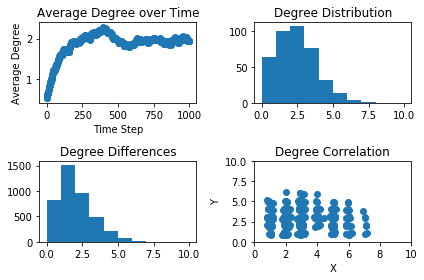

In [73]:
n_males = n_females = 200 # number of male and female nodes
d_m = 10 # degree cutoff for tie formation
p_f = 0.0001 # probability of tie formation
p_d = 0.01 # probability of tie dissolution
T = 1000 # number of time steps to simulate;
mixing = "random" #type of mixing

Start = generate_network(n_males, n_females, d_m, p_f, p_d, T, mixing)


make_plots(Start[1], n_males, n_females, Start[2], T, Start[0], d_m)

# Assortative Mixing

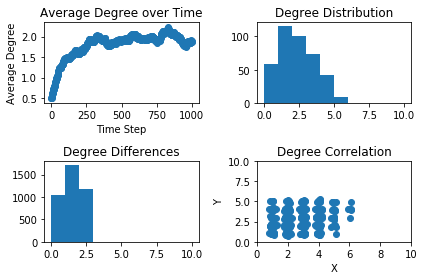

In [74]:
n_males = n_females = 200 # number of male and female nodes
d_m = 10 # degree cutoff for tie formation
p_f = 0.0001 # probability of tie formation
p_d = 0.01 # probability of tie dissolution
T = 1000 # number of time steps to simulate;
mixing = "assort" #type of mixing

Start = generate_network(n_males, n_females, d_m, p_f, p_d, T, mixing)


make_plots(Start[1], n_males, n_females, Start[2], T, Start[0], d_m)

# Disassortive Mixing

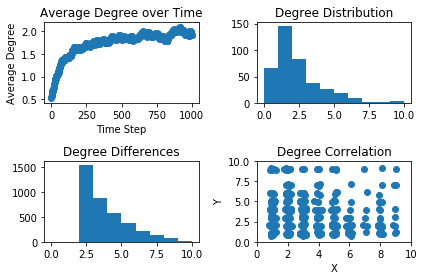

In [75]:
n_males = n_females = 200 # number of male and female nodes
d_m = 10 # degree cutoff for tie formation
p_f = 0.0001 # probability of tie formation
p_d = 0.01 # probability of tie dissolution
T = 1000 # number of time steps to simulate;
mixing = "disassort" #type of mixing

Start = generate_network(n_males, n_females, d_m, p_f, p_d, T, mixing)


make_plots(Start[1], n_males, n_females, Start[2], T, Start[0], d_m)

## Comments

Comment on the results, in particular on the following aspects: (i) Does the average degree appear to saturate by the end of the simulation; (ii) Does the degree-degree scatter plot reflect the type of tie formation mechanism that was used to construct the network; (iii) Is the histogram of `deg_diffs` values consistent with model specification? For example, for the assortative case, degree difference is allowed to have values 0, 1 and 2. There may however be a non-zero probability on slightly higher values.

In three cases, random mixing; assortative mixing; and disassortative mixing, the average degree does appear to saturate by the end. At various rates, each model approached an average degree of ~2. Random mixing led to saturation at approximately time 250. Assortative mixing led to saturation between time 250 and 500. Disassortative mixing led to saturation before time 250.  

The degree-degree scatter plot also lends us insight. Disassortative mixing methods yield greater variability and larger degrees. Assortative mixing methods yield smaller variability. Degrees tended to be tightly clustered. Random mixing is more variable than assortative mixing but less variable than disassortative mixing. The largest degrees in random mixing are not as large as the largest degrees in disassortative mixing.

Using a threshold value of 2, we expect there to not be absolute degree differences larger than 2 in assortative mixing. However, in our initial mixing, we allowed for 100 random ties to form. When we formed random ties, we limited the number of degrees per node to 10. Some nodes could potentially accumulate many "connections" during this time and the absolute degree differences would then typically be large if they again connected with a previously unconnected network. Likewise for disassortative mixing, we see that we have absolute degree differences smaller than 2 despite specifying otherwise. This is because when we seeded the network, we used random mixing. Random mixing permits degree differences smaller than and greater than 2. However, I did not track degree differences in this initial seeding. 

## Question 5: Propagating epidemics on networks

In this final question, we will propagate an SIR process on the three different networks we generated above. As the first step, extract the largest connected component (LCC) of each network and run all spreading processes on these components rather than the whole network. Write code to run an SIR spreading process 1000 times for 100 time steps on each network LCC. Use 0.2 for the S -> I transition probability, 0.05 for the I -> R transition probability, and to initialize the process use 10 seed nodes. Keep track of the number of nodes in the R state at the end of each simulation (at time = 100), which can be interpreted as the size of the epidemic at this point in time. Print out the average number of R nodes at time = 100, where the average is computed over the 1000 spreading process realizations. You should be able to reuse the code from Lab 3 in this question. For better averaging, we should really generate different network realizations as well as use larger networks, but to simplify things and save computation time, we use three relatively small fixed networks for all simulations. How does assortativity or disassortativity influence the size of the epidemic? You can repeat network generation a few times and rerun the spreading process, although you don't need to document that here.

In [76]:
# YOUR CODE HERE
N1 = generate_network(n_males, n_females, d_m, p_f, p_d, T, "random")[0]
c1 = sorted(nx.connected_components(N1), key=len, reverse=True)
N1_LCC = N1.subgraph(c1[0])
N2 = generate_network(n_males, n_females, d_m, p_f, p_d, T, "assort")[0]
c2 = sorted(nx.connected_components(N2), key=len, reverse=True)
N2_LCC = N2.subgraph(c2[0])
N3 = generate_network(n_males, n_females, d_m, p_f, p_d, T, "disassort")[0]
c3 = sorted(nx.connected_components(N3), key=len, reverse=True)
N3_LCC = N3.subgraph(c3[0])

In [77]:
#recovery process
def recover(i_nodes , r_nodes , p):
    new_recoveries = []
    for node in i_nodes:
        if random.random() < p:
            new_recoveries.append(node)
    for node in new_recoveries:
        r_nodes.append(node)
        i_nodes.remove(node)
    return new_recoveries

#spreading process
def spread(G, s_nodes , i_nodes , p):
    new_infections = set ()
    for node in i_nodes:
        if G.degree(node) > 0:
            neighbor = random.choice( list (G.neighbors(node)))
            if (neighbor in s_nodes) and (random.random() < p):
                new_infections.add(neighbor)
    for node in new_infections:
        i_nodes.append(node)
        s_nodes.remove(node)
    return new_infections

#sumulate the process
def simulate(G, p_si , p_ir , num_seeds , num_time_steps):

    # Initialize some objects .
    i_nodes = random.sample(G.nodes(), num_seeds)
    s_nodes = list ( set (G.nodes()) - set (i_nodes))
    r_nodes = []
    num_s_nodes = [ len(s_nodes)]
    num_i_nodes = [ len(i_nodes)]
    num_r_nodes = [ len(r_nodes)]

    # Loop over all time steps .
    for step in range (1, num_time_steps):
        new_recoveries = recover(i_nodes , r_nodes , p_ir)
        new_infections = spread(G, s_nodes , i_nodes , p_si)
        num_s_nodes.append( len (s_nodes))
        num_i_nodes.append( len (i_nodes))
        num_r_nodes.append( len (r_nodes))
        if len (i_nodes) == 0:
            break
    return (num_s_nodes[-1] , num_i_nodes[-1] , num_r_nodes[-1])

def mean(x):
    return(sum(x)/len(x))

## Random Mixing

In [78]:
G = N1_LCC
p_si = 0.2
p_ir = 0.05
num_seeds = 10
num_time_steps = 100
#num_s_nodes = []
#num_i_nodes = []
#num_r_nodes = []

mean1 = []
var1 = []
for i in range(5):
    num_s_nodes = []
    num_i_nodes = []
    num_r_nodes = []
    for t in range(1000):
        Iter = simulate(G,  p_si , p_ir , num_seeds , num_time_steps)
        num_s_nodes.append(Iter[0])
        num_i_nodes.append(Iter[1])
        num_r_nodes.append(Iter[2])
        if t%100 == 0:
            print(t)
    mean1.append(mean(num_r_nodes))
    var1.append(np.var(num_r_nodes))
    

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


In [81]:
print(mean1)
print(mean(mean1)/nx.number_of_nodes(N1_LCC))

[62.834, 63.008, 64.895, 64.547, 64.67]
0.19872919254658386


## Assortative Mixing

In [82]:
G = N2_LCC
p_si = 0.2
p_ir = 0.05
num_seeds = 10
num_time_steps = 100
#num_s_nodes2 = []
#num_i_nodes2 = []
#num_r_nodes2 = []

mean2 = []
var2 = []
for i in range(5):
    num_s_nodes2 = []
    num_i_nodes2 = []
    num_r_nodes2 = []
    for t in range(1000):
        Iter = simulate(G,  p_si , p_ir , num_seeds , num_time_steps)
        num_s_nodes2.append(Iter[0])
        num_i_nodes2.append(Iter[1])
        num_r_nodes2.append(Iter[2])
        if t%100 == 0:
            print(t)
    mean2.append(mean(num_r_nodes2))
    var2.append(np.var(num_r_nodes2))    

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


In [83]:

print(mean2)
print(mean(mean2)/nx.number_of_nodes(N2_LCC))

[69.907, 69.72, 69.13, 69.552, 69.856]
0.24262369337979098


## Disassortative Mixing

In [84]:
G = N3_LCC
p_si = 0.2
p_ir = 0.05
num_seeds = 10
num_time_steps = 100
#num_s_nodes3 = []
#num_i_nodes3 = []
#num_r_nodes3 = []


mean3 = []
var3 = []
for i in range(5):
    num_s_nodes3 = []
    num_i_nodes3 = []
    num_r_nodes3 = []
    for t in range(1000):
        Iter = simulate(G,  p_si , p_ir , num_seeds , num_time_steps)
        num_s_nodes3.append(Iter[0])
        num_i_nodes3.append(Iter[1])
        num_r_nodes3.append(Iter[2])
        if t%100 == 0:
            print(t)
    mean3.append(mean(num_r_nodes3))
    var3.append(np.var(num_r_nodes3))

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


In [88]:

print(mean3)
print(mean(mean3)/nx.number_of_nodes(N3_LCC))


[83.027, 83.345, 84.641, 84.47, 83.844]
0.262079375
83.86540000000001


## Comments

We run the SIR process over five times for 1,000 iterations for 100 time steps, and we observe different effects for the three tie-formation mechanisms. Measuring the size of the epidemic at time T = 100 with the R (recovered) nodes, we see that assortative networks have the medium-sized epidemics (R=[69.907, 69.72, 69.13, 69.552, 69.856]), disassortative networks have larger epidemics (R = [83.027, 83.345, 84.641, 84.47, 83.844]), and random networks can have the any-size epidemics (R = [62.834, 63.008, 64.895, 64.547, 64.67]). We can see that clearly the choice between assortative and disassortative sorting has an effect on epidemic size. These numbers are somewhat misleading. Although the largest epidemic in terms of total recovered was in the disassortative mixing network, the proportion of recovered individuals in the disassortative was only slightly larger than the proportion in the assortative model.

Overall, I actually can't be entirely sure. My results varied for different configurations (3) of the network. In the first instance, random networks and disassortative were both similar in size and larger than assortative. In the next configuration, disassortative and assortative were similar in size although disassortative was slightly larger. In my final configuration which I show, disassortative was larger than assortative and both were larger than assortative. 

From what I saw, the disassortative had a larger reach and the epidemic could infect more people but moved more slowly throughout the network, and assortative had a faster movement. A fast moving epidemic could move through a network quickly and leave an equal number of recovered individuals when compared to a slower moving but further reaching.    